In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

In [2]:
from IPython.core.debugger import set_trace

from pathlib import Path
import json
from matplotlib import patches, patheffects
from scipy.special import expit

from fastai.conv_learner import *
from fastai.dataset import *



#### Reproduced from memory only around 10% of the code here

In [3]:
plt.ion()

In [4]:
#TODO symlink data to Data/fastai
PATH = Path('/mnt/samsung_1tb/Data/fastai/pascal/pascal_direct')

In [5]:
#images: is list of {file_name, height, width, id}
#annotations:[{"segmentation":[[155,96,155,270,351,270,351,96]],"area":34104,"iscrowd":0,"image_id":12,"bbox":[155,96,196,174],"category_id":7,"id":1,"ignore":0}
#categories:[{"supercategory":"none","id":1,"name":"aeroplane"}
trn_j = json.load((PATH / 'pascal_train2007.json').open())

In [6]:
IMAGES,ANNOTATIONS,CATEGORIES = ['images', 'annotations', 'categories']
trn_j[ANNOTATIONS][:2]

[{'area': 34104,
  'bbox': [155, 96, 196, 174],
  'category_id': 7,
  'id': 1,
  'ignore': 0,
  'image_id': 12,
  'iscrowd': 0,
  'segmentation': [[155, 96, 155, 270, 351, 270, 351, 96]]},
 {'area': 13110,
  'bbox': [184, 61, 95, 138],
  'category_id': 15,
  'id': 2,
  'ignore': 0,
  'image_id': 17,
  'iscrowd': 0,
  'segmentation': [[184, 61, 184, 199, 279, 199, 279, 61]]}]

In [7]:
trn_j[CATEGORIES][:2]

[{'id': 1, 'name': 'aeroplane', 'supercategory': 'none'},
 {'id': 2, 'name': 'bicycle', 'supercategory': 'none'}]

In [13]:
FILE_NAME,ID,IMG_ID,CAT_ID,BBOX = 'file_name','id','image_id','category_id','bbox'

cats = dict((o[ID], o['name']) for o in trn_j[CATEGORIES])
#eg {1: 'aeroplane', 2: 'bicycle',
trn_fns = dict((o[ID], o[FILE_NAME]) for o in trn_j[IMAGES])
#eg {12: '000012.jpg', 17: '000017.jpg',
trn_ids = [o[ID] for o in trn_j[IMAGES]]
#eg[12, 17, 23, 

In [11]:
first_image = trn_j[IMAGES][0]
print(f'file_name: {first_image[FILE_NAME]}, id: {first_image[ID]}')

file_name: 000012.jpg, id: 12


In [12]:
trn_anno = collections.defaultdict(lambda:[])
#"annotations":[{"segmentation":[[52,86,52,420,471,420,471,86]],"area":139946,"iscrowd":0,"image_id":2008000008,"bbox":[52,86,419,334],"category_id":13,"id":1,"ignore":0},
for o in trn_j[ANNOTATIONS]:
    if not o['ignore']:
        bb = o[BBOX]
        bb = np.array([bb[1], bb[0], bb[3]+bb[1]-1, bb[2]+bb[0]-1])
        trn_anno[o[IMG_ID]].append((bb,o[CAT_ID]))

In [13]:
#trn_anno is a dict of {id, [(bbox, category_id), ...]} where coords are now TL, BR and numpy consistent x,y coords
im_a = trn_anno[first_image[ID]]; im_a

[(array([ 96, 155, 269, 350]), 7)]

In [14]:
im_0a = im_a[0]

In [15]:
#conversion between numpy style and cs style
def bb_hw(a): 
    return np.array([a[1],a[0],a[3]-a[1],a[2]-a[0]])

In [16]:
im = open_image(IMG_PATH/first_image[FILE_NAME])

In [17]:
def show_img(im, figsize=None, ax=None):
    if not ax: fig,ax = plt.subplots(figsize=figsize)
    ax.imshow(im)
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    return ax

In [18]:
def draw_outline(o, lw):
    o.set_path_effects([patheffects.Stroke(
        linewidth=lw, foreground='black'), patheffects.Normal()])

In [19]:
def draw_rect(ax, b):
    patch = ax.add_patch(patches.Rectangle(b[:2], *b[-2:], fill=False, edgecolor='white', lw=2))
    draw_outline(patch, 4)

In [20]:
def draw_text(ax, xy, txt, sz=14):
    text = ax.text(*xy, txt,
        verticalalignment='top', color='white', fontsize=sz, weight='bold')
    draw_outline(text, 1)

In [21]:
def draw_im(im, ann):
    ax = show_img(im, figsize=(16,8))
    for b,c in ann:
        b = bb_hw(b)
        draw_rect(ax, b)
        draw_text(ax, b[:2], cats[c], sz=16)

In [22]:
def draw_idx(i):
    im_a = trn_anno[i]
    im = open_image(IMG_PATH/trn_fns[i])
    print(im.shape)
    draw_im(im, im_a)

## Largest Item Classifier

In [23]:
def get_lrg(b):
    if not b: 
        raise Exception()
    b = sorted(b, key=lambda x: np.product(x[0][-2:]-x[0][:2]), reverse=True)
    return b[0]

In [24]:
#b[0]: (array([ 96, 155, 269, 350]), 7), b[0][-2:]: (array([ 96, 155, 269, 350]), 7), b[0][:2]: (array([ 96, 155, 269, 350]), 7)
#b[0]: (array([ 96, 155, 269, 350]), 7), b[0][0]: [ 96 155 269 350], b[0][:2]: (array([ 96, 155, 269, 350]), 7)


In [25]:
trn_lrg_anno = {a: get_lrg(b) for a,b in trn_anno.items()}

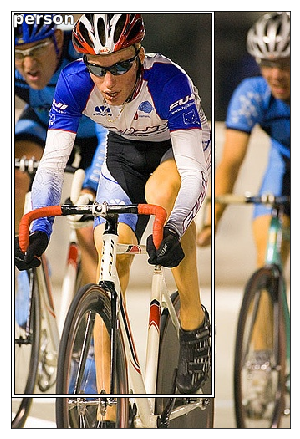

<Figure size 432x288 with 0 Axes>

In [26]:
b,c = trn_lrg_anno[23]
b = bb_hw(b)
ax = show_img(open_image(IMG_PATH/trn_fns[23]), figsize=(5,10))
draw_rect(ax, b)
draw_text(ax, b[:2], cats[c], sz=16)
plt.show()
plt.savefig('temp.png')

In [27]:
(PATH/'tmp').mkdir(exist_ok=True)
CSV = PATH/'tmp/lrg.csv'

In [28]:
print(PATH)


/mnt/samsung_1tb/Data/fastai/pascal/pascal_direct


In [29]:
df = pd.DataFrame({'filename': [trn_fns[o] for o in trn_ids],
                  'category': [cats[trn_lrg_anno[o][1]] for o in trn_ids]}, columns = ['filename', 'category'])
df.to_csv(CSV, index=False)

In [30]:
df.head(n=2)

filename category
0  000012.jpg      car
1  000017.jpg    horse

In [31]:
f_model = resnet34
size = 224
bs = 64

In [ ]:
transforms = tfms_from_model(f_model, sz=size, aug_tfms=transforms_side_on, crop_type = CropType.NO)
model_data = ImageClassifierData.from_csv(PATH, JPEGS, CSV, tfms=transforms)

In [33]:
#grab a single batch, x is independent, y is dependent variable
x, y = next(iter(model_data.val_dl))
#need to convert x to numpy array

show_img(model_data.val_ds.denorm(to_np(x))[0])


In [34]:
learn = ConvLearner.pretrained(f_model, model_data, metrics=[accuracy])
#torch.optim has various optimization algos
learn.opt_fn = optim.Adam

In [35]:
learn.lr_find()

HBox(children=(IntProgress(value=0, description='Epoch', max=1), HTML(value='')))

 88%|████████▊ | 28/32 [00:04<00:00,  5.96it/s, loss=13.7]


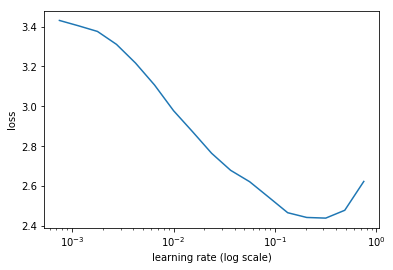

In [36]:
#looks weird if dont set n_skip_end as by default we remove first and last few points ie:
#plot(self, n_skip=10, n_skip_end=5)
learn.sched.plot(n_skip_end=2)

In [37]:
lr = 1e-1

In [38]:
learn.fit(lrs=lr, n_cycle=1, cycle_len=1)

HBox(children=(IntProgress(value=0, description='Epoch', max=1), HTML(value='')))

epoch      trn_loss   val_loss   accuracy   
    0      2.558169   1.247272   0.803486  



[1.2472723, 0.8034855797886848]

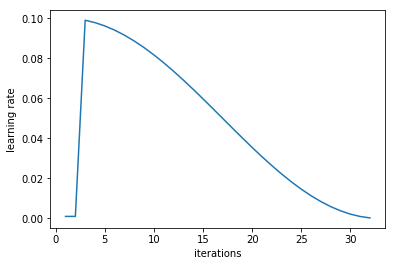

In [39]:
learn.sched.plot_lr()

In [40]:
x, y 
#print(f'{layer_groups}, {len(layer_groups)}')


In [41]:
#final layer, set lr to 1e-1, ~50/50 split of lr for prev layers
lrs = np.array([lr/1000, lr/100, lr])

In [42]:
learn.freeze_to(-2)

In [43]:
lrf = learn.lr_find(lrs/1000)

HBox(children=(IntProgress(value=0, description='Epoch', max=1), HTML(value='')))

 84%|████████▍ | 27/32 [00:05<00:01,  4.62it/s, loss=8.16]


In [44]:
#Was getting an error when LayerOptimizer checks that len(layer_groups) is = len(lrs)as have one layer group (TODO check if lr_find fixed this)
learn.fit(lrs=lrs/5, n_cycle=1, cycle_len=1)

HBox(children=(IntProgress(value=0, description='Epoch', max=1), HTML(value='')))

epoch      trn_loss   val_loss   accuracy   
    0      1.956274   1.160122   0.772837  



[1.1601222, 0.7728365361690521]

In [45]:
#In layer_optimizer we can (re)set the lrearning rates
#first we need to initialize the optimizer
#could do this: var_iter = next(iter(model_data.val_dl)) but we need Varibles not FloatTensors
#opt_adam = optim.Adam(params = VV(x), lr = lr)
#set_lrs(opt_adam, lrs=lrs)

In [46]:
learn.unfreeze()

In [47]:
learn.fit(lrs=lrs/5, n_cycle=1, cycle_len=1)

HBox(children=(IntProgress(value=0, description='Epoch', max=1), HTML(value='')))

epoch      trn_loss   val_loss   accuracy   
    0      1.266036   0.984673   0.774339  



[0.9846733, 0.7743389457464218]

In [48]:
learn.save('clas_one')
learn.load('clas_one')

In [49]:
x, y = next(iter(model_data.val_dl))
x[0]


( 0 ,.,.) = 
  3.9125e-01  4.3014e-01  4.8172e-01  ...   1.7518e-01  3.2367e-01  4.0783e-01
  5.1636e-01  4.4973e-01  5.9202e-01  ...   1.7386e-01  2.3164e-01  3.6722e-01
  5.4416e-01  5.7267e-01  7.0099e-01  ...   5.7682e-02  2.2320e-01  3.5455e-01
                 ...                   ⋱                   ...                
  1.4604e+00  1.5029e+00  1.5195e+00  ...   7.8030e-01  5.6716e-01 -6.3922e-01
  9.3739e-01  1.0210e+00  1.1599e+00  ...   1.1281e+00  1.0895e+00  4.5857e-01
  5.8584e-01  4.5245e-01  2.9605e-01  ...   1.0003e+00  9.2495e-01  8.2729e-01

( 1 ,.,.) = 
  2.4041e-01  3.1444e-01  4.1422e-01  ...   3.3162e-01  4.7052e-01  5.4764e-01
  3.9737e-01  4.2156e-01  5.7304e-01  ...   3.3887e-01  3.8799e-01  5.2038e-01
  5.2462e-01  5.8245e-01  6.7485e-01  ...   2.5190e-01  4.0003e-01  5.1502e-01
                 ...                   ⋱                   ...                
  1.4721e+00  1.5019e+00  1.5077e+00  ...   6.0917e-01  4.4337e-01 -7.3978e-01
  8.4169e-01  9.4566e-01

In [50]:
#model.eval() Sets the module in evaluation mode - batchnorm and dropout are disabled
#self.training is set to False
#predict batch converts x to Variable
batch_preds = predict_batch(learn.model, x)


In [51]:
batch_preds  #bs by classes tensor

Variable containing:
-18.2956  -1.8022 -12.2445  ...  -18.3967 -16.2560 -22.9768
-23.0212 -14.1703 -17.8084  ...   -4.2041 -21.6045 -10.1153
-19.2190 -21.2912  -0.0002  ...  -24.1157 -18.0703 -20.0977
           ...               ⋱              ...            
-17.7602  -9.1107 -11.1734  ...   -4.7239 -16.8874 -10.6530
-41.1937 -21.6626 -27.3252  ...  -23.5806 -42.2180 -33.9634
-15.6721 -13.6216 -15.4532  ...  -17.3071 -13.2107 -14.2052
[torch.cuda.FloatTensor of size 64x20 (GPU 0)]

In [52]:
#compute along the class dimension, setting dim to -1 (as per lecture), None or 1 all prod same result
probs = F.softmax(batch_preds, -1)
probs

Variable containing:
 1.1333e-08  1.6494e-01  4.8116e-06  ...   1.0243e-08  8.7119e-08  1.0503e-10
 1.0047e-10  7.0133e-07  1.8447e-08  ...   1.4934e-02  4.1429e-10  4.0454e-05
 4.5007e-09  5.6672e-10  9.9980e-01  ...   3.3625e-11  1.4195e-08  1.8692e-09
                ...                   ⋱                   ...                
 1.9358e-08  1.1048e-04  1.4043e-05  ...   8.8807e-03  4.6334e-08  2.3631e-05
 1.2876e-18  3.9087e-10  1.3578e-12  ...   5.7420e-11  4.6231e-19  1.7778e-15
 1.5620e-07  1.2140e-06  1.9443e-07  ...   3.0452e-08  1.8309e-06  6.7729e-07
[torch.cuda.FloatTensor of size 64x20 (GPU 0)]

In [53]:
x = to_np(x)
preds = to_np(probs)


In [54]:
#get indices of max values (returns the indices of the maximum values along an axis.)
preds = np.argmax(preds, -1)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


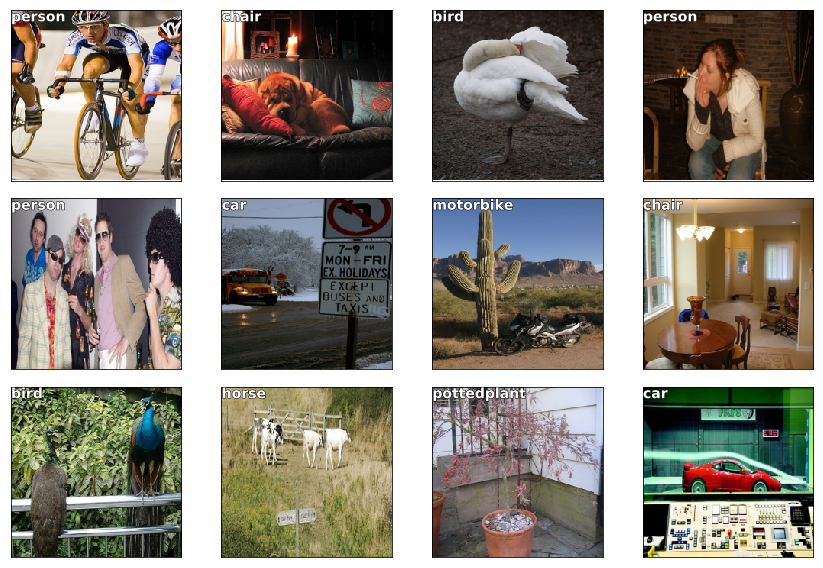

In [55]:
#draw the predictions
fig, axes = plt.subplots(3, 4, figsize = (12, 8))
for i,ax in enumerate(axes.flat):
    ima=model_data.val_ds.denorm(x)[i]
    b = model_data.classes[preds[i]]
    ax = show_img(ima, ax=ax)
    draw_text(ax, (0, 0), b)
plt.tight_layout()
plt.show()

In [56]:
#lecture 9 start reviews this part of lecture 8

### Bbox only

In [57]:

#create a model data object for bboxes
#create a model data object for classses
#combine these into one model

In [58]:
BB_CSV = PATH/'tmp/bb.csv'


In [59]:
bb = np.array([trn_lrg_anno[o][0] for o in trn_ids])
#want space sep data
bbs = [' '.join(str(p) for p in o) for o in bb]

df = pd.DataFrame({'fn': [trn_fns[o] for o in trn_ids], 'bbox': bbs}, columns=['fn', 'bbox'])
df.to_csv(BB_CSV, index=False)

In [60]:
BB_CSV.open().readlines()[:5]

['fn,bbox\n',
 '000012.jpg,96 155 269 350\n',
 '000017.jpg,77 89 335 402\n',
 '000023.jpg,1 2 461 242\n',
 '000026.jpg,124 89 211 336\n']

In [61]:
#define architecture
f_model = resnet34
sz = 224
bs = 64

In [62]:
#lighting is image-average*b + c
augs = [RandomFlip(), RandomRotate(20), RandomLighting(b=0.1, c=0.1)]
augs

In [63]:
tfms = tfms_from_model(f_model=f_model, sz=sz, aug_tfms=augs)
#classifiers are categorical, here doing regression
# if continuous=True then label_arr = np.array([np.array(csv_labels[i]).astype(np.float32) for i in fnames])
model_data = ImageClassifierData.from_csv(PATH, JPEGS, csv_fname=BB_CSV, bs=bs, tfms = tfms, continuous=True)

In [64]:
#draw images and bboxes - note problems with bbox locations - need to transform this in same way as indeprendant var
idx=3
fig, axes = plt.subplots(3, 3, figsize=(9,9))
for i, ax in enumerate(axes.flat):
    x,y = next(iter(model_data.aug_dl))
    ima = model_data.val_ds.denorm(to_np(x))[idx]
    b = bb_hw(to_np(y[idx]))
    print(f'b {b}')
    show_img(ima, ax=ax)
    draw_rect(ax, b)

b [115.  63. 240. 311.]
b [115.  63. 240. 311.]
b [115.  63. 240. 311.]
b [115.  63. 240. 311.]
b [115.  63. 240. 311.]
b [115.  63. 240. 311.]
b [115.  63. 240. 311.]
b [115.  63. 240. 311.]
b [115.  63. 240. 311.]


In [65]:
augs = [RandomFlip(tfm_y=TfmType.COORD),
        RandomRotate(30, tfm_y=TfmType.COORD),
        #I havent set tfm_y for lighting - I assume wont have any impact
        RandomLighting(0.1,0.1)]

In [66]:
#tfm_y: y axis specific transformations
tfms = tfms_from_model(f_model, sz, aug_tfms=augs, crop_type=CropType.NO, tfm_y=TfmType.COORD)
model_data = ImageClassifierData.from_csv(PATH, JPEGS, csv_fname=BB_CSV, bs=64, tfms=tfms)
model_data

In [22]:

idx=3
fig, axes = plt.subplots(3, 3, figsize=(9,9))
for i, ax in enumerate(axes.flat):
    x,y = next(iter(model_data.aug_dl))
    ima = model_data.val_ds.denorm(to_np(x))[idx]
    b = bb_hw(to_np(y[idx]))
    #TODO fix bug with b coordinates
    print(f'b {b}')
    show_img(ima, ax=ax)
    draw_rect(ax, b)

NameError: name 'model_data' is not defined

In [68]:
#now we create a model where we rotate 50% of the time 9 mins on video
tfm_y = TfmType.COORD
augs = [RandomFlip(tfm_y=tfm_y),
        #rotate up to 3% 50% of time
        RandomRotate(3, p=0.5, tfm_y=tfm_y),
        RandomLighting(0.05, 0.05, tfm_y=tfm_y)]

In [69]:
tfms = tfms_from_model(f_model, sz,aug_tfms=augs, crop_type=CropType.NO, tfm_y=tfm_y)
#path, folder, csv_fname, bs=64, tfms
model_data = ImageClassifierData.from_csv(PATH, JPEGS, BB_CSV, bs=bs, tfms=tfms, continuous=True)

In [70]:
#learn.summary()

#...
#Conv2d-119',
#BatchNorm2d-120',
#'ReLU-121',
#'BasicBlock-122',
#end of convolutional section - where head will be put

In [71]:
#create a custom head, 512*7*7 = 25088. 4 bounding box coords
#Dont want to add standard fully connected layers that make up a classifier, want a single linear with 4 outputs
#flattens out, this is a simple final layer. 25088=512x7x7
head_reg4 = nn.Sequential(Flatten(), nn.Linear(in_features=25088, out_features=4))
#custom head wont create any of the fully connected network, wont add the adaptive average pooling, instead will add the model you specify
#note that f_model is resnet34
#stick this on a pretrained model
learn = ConvLearner.pretrained(f_model, data = model_data, custom_head=head_reg4)
learn.opt_fn = optim.Adam
#L1 Loss function minimizes the absolute differences between the estimated values and the target values
learn.crit = nn.L1Loss()

In [72]:
learn.lr_find()

HBox(children=(IntProgress(value=0, description='Epoch', max=1), HTML(value='')))

 91%|█████████ | 29/32 [00:05<00:00,  5.55it/s, loss=471]


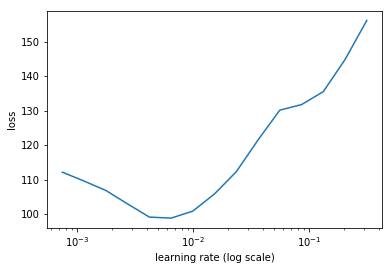

In [73]:
learn.sched.plot()

In [74]:
lr = 2e-3

In [75]:
learn.fit(lr, n_cycle=2, cycle_len=1, cycle_mult=2)

HBox(children=(IntProgress(value=0, description='Epoch', max=3), HTML(value='')))

epoch      trn_loss   val_loss   
    0      49.233286  34.53231  
    1      37.345884  27.679638 
    2      31.461656  27.265064 



[27.265064]

In [76]:
lrs = np.array([lr/100, lr/10, lr])
layer_groups = learn.get_layer_groups()

In [77]:
groups_freeze_to = layer_groups[-2:]
#groups_freeze_to


In [78]:
#why not just freeze last group?
learn.freeze_to(-2)

HBox(children=(IntProgress(value=0, description='Epoch', max=1), HTML(value='')))

epoch      trn_loss   val_loss   
    0      69.880439  1140833776566272.0



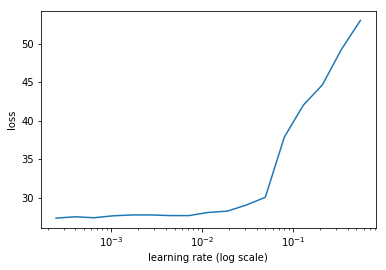

In [79]:
learn.lr_find(lrs/1000)
learn.sched.plot()

In [80]:
learn.fit(lrs, 2, cycle_len=1, cycle_mult=2)

HBox(children=(IntProgress(value=0, description='Epoch', max=3), HTML(value='')))

epoch      trn_loss   val_loss   
    0      26.196967  22.484734 
    1      23.111301  21.07     
    2      20.026255  20.127628 



[20.127628]

In [81]:
learn.freeze_to(-3)

In [82]:
learn.fit(lrs, 1, cycle_len=2)

HBox(children=(IntProgress(value=0, description='Epoch', max=2), HTML(value='')))

epoch      trn_loss   val_loss   
    0      18.678035  21.112558 
    1      16.532662  19.874186 



[19.874186]

In [83]:
learn.save('reg4')
learn.load('reg4')

In [84]:
x, y = next(iter(model_data.val_dl))
learn.model.eval()
preds = to_np(learn.model(VV(x)))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


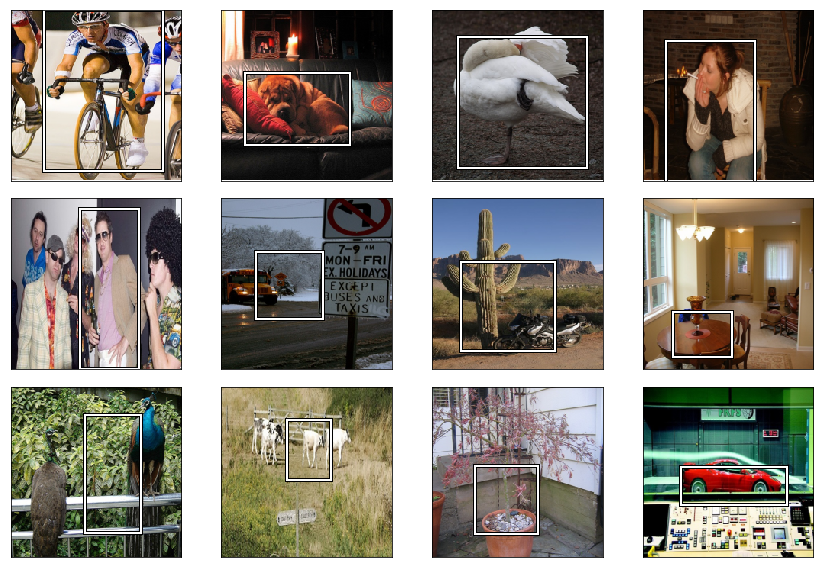

In [85]:
fig, axes = plt.subplots(3,4, figsize=(12,8))
for i, ax in enumerate(axes.flat):
    ima = model_data.val_ds.denorm(to_np(x))[i]
    b = bb_hw(preds[i])
    ax = show_img(ima, ax=ax)
    draw_rect(ax, b)
plt.tight_layout()


## Single object detection


In [86]:
#bounding box and largest object
f_model = resnet34
sz = 224
bs = 64


In [87]:
#Workflow:

#create two models
#md as bbox coords
#md2 as classes
#then merge as a new dataset class

In [88]:
#note here we are passing in to the ModelData val_idx
#trn_fns = dict((o[ID], o[FILE_NAME]) for o in trn_j[IMAGES])
#get indexes for a validations set (80/20 default split); index of images to be used for validation
val_idxs = get_cv_idxs(len(trn_fns))

In [89]:
tfms = tfms_from_model(f_model,sz=sz, aug_tfms=augs, crop_type=CropType.NO, tfm_y=TfmType.COORD)
#BB_CSV contains only filename, bbox coords
md = ImageClassifierData.from_csv(PATH, JPEGS, BB_CSV, bs=bs, tfms=tfms, continuous=True, val_idxs=val_idxs)
print(f'{type(md)}, size: {md.sz}')

<class 'fastai.dataset.ImageClassifierData'>, size: 224


In [90]:
tfms2 = tfms_from_model(f_model, sz=sz, aug_tfms=transforms_side_on, crop_type=CropType.NO)
#note we are reading in the CSV not BB_CSV, CSV contains only filename, category
md2 = ImageClassifierData.from_csv(PATH, JPEGS, CSV, bs=bs, tfms=tfms2)
md2.sz

224

In [91]:
#ImageClassifierData <-ImageData (has own proerties eg sz which returns self.trn_ds.sz) <-ModelData (has own properties eg trn_ds which returns self.trn_dl.dataset)
#but ConcatLblDataset has none of these properties as extends pytorch Dataset directly

In [92]:
class ConcatLblDataset(Dataset):
    #take existing ds which has existing independent and dependant vars, add in dependent y2
    #extends torch Dataset, which requires one to override the methods below
    #sz property added as is required by learner (lean.summary())
    def __init__(self, ds, ds2):
        #I changed this to use seconds dataset rater than just y to help me understand this
        self.ds = ds
        self.ds2 = ds2
        
    def __len__(self):
        assert len(self.ds) == len(self.ds2)
        return len(self.ds)

    def __getitem__(self, i):
        x, y = self.ds[i]
        x2, y2 = self.ds2[i]
        #these should contain exactly the same info, so we only need to keep one. However this test fails
        #assert np.array_equal(x,x2)
        return (x, (y, y2))
    
    @property
    def sz(self):
        x, y = self.ds[0]
        print(f'sz: {x.shape[1]}')
        return x.shape[1]

In [93]:
#the bbox tagets
md.trn_ds.y

array([[ 96., 155., 269., 350.],
       [ 77.,  89., 335., 402.],
       [  1.,   2., 461., 242.],
       ...,
       [198.,  91., 228., 131.],
       [ 89.,  24., 311., 426.],
       [141., 191., 186., 329.]], dtype=float32)

In [94]:
#classification dependent variable
md2.trn_ds.y

array([ 6, 12, 14, ..., 16, 14,  6])

In [95]:
#NB I changed the ConcatLblDataset. now it takes two datasets
trn_ds2 = ConcatLblDataset(md.trn_ds, md2.trn_ds)
val_ds2 = ConcatLblDataset(md.val_ds, md2.val_ds)

In [96]:
val_ds2[0][1]

(array([  0.,  49., 205., 180.], dtype=float32), 14)

In [97]:
md.trn_dl.dataset = trn_ds2
md.val_dl.dataset = val_ds2
print(f'{type(md)}')
#Note that now in ImageData self.trn_ds.sz is no longer a valid property

<class 'fastai.dataset.ImageClassifierData'>


In [98]:
x, y = next(iter(md.val_dl))
idx=3
ima = md.val_ds.ds.denorm(to_np(x))[idx]
b = bb_hw(to_np(y[0][idx])); b

array([ 52.,  38., 106., 184.], dtype=float32)

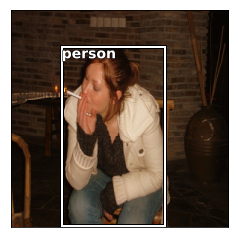

In [99]:
ax = show_img(ima)
draw_rect(ax,b)
draw_text(ax, b[:2], md2.classes[y[1][idx]])
plt.show()

In [100]:
#replace head, similar to before but add an extra linear layer and add dropout
head_reg4 = nn.Sequential(
    Flatten(), 
    nn.ReLU(),
    nn.Dropout(0.5),
    #this is a helper linear layer
    nn.Linear(in_features=512*7*7, out_features=256),
    nn.ReLU(),
    #1d as we have flattened 
    nn.BatchNorm1d(256),
    nn.Dropout(0.5),
    #note at this stage we only have 256 in_features
    nn.Linear(in_features=256, out_features= 4+len(cats))
)


In [101]:
#ConvnetBuilder(f, c, is_multi, is_reg, ps=None, xtra_fc=None, xtra_cut=0, custom_head=None)
#why is c (final layer size) zero, shouldn't it be 4+len(cats)?
model_arch = ConvnetBuilder(f=f_model, c=0, is_multi=False, is_reg=False, custom_head=head_reg4)

In [102]:
learn = ConvLearner(data = md, models = model_arch)

In [103]:
learn.opt_fn = optim.Adam

In [104]:
#loss fn needs to look at 4+C activations & decide if good
#for 4 coords - L1 loss which is like MSE but sums abs vals
#for C use cross-entropy loss
def detn_loss(input, target):
    bb_t, c_t = target
    #first dim is batch dim, input first 4, and 4 onwards elements
    bb_i, c_i = input[:, :4], input[:, 4:]
    #for bb_i we know they will be b/w 0 & 224
    #use sigmoid to force b/w 0&1 and force the range
    bb_i = F.sigmoid(bb_i)*224
    #scalar for classifications based on what works
    combined_loss = F.l1_loss(bb_i, bb_t) + F.cross_entropy(c_i, c_t)*20
    return combined_loss
    
def detn_l1(input, target):
    bb_t, _ = target
    bb_i = input[:, :4]
    bb_i = F.sigmoid(bb_i)*224
    f1_loss = F.l1_loss(V(bb_i), V(bb_t)).data
    return f1_loss

def detn_acc(input, target):
    _,c_t = target
    c_i = input[:,4:]
    return accuracy(c_i, c_t)

learn.crit = detn_loss
learn.metrics = [detn_acc, detn_l1]
    

HBox(children=(IntProgress(value=0, description='Epoch', max=1), HTML(value='')))

 94%|█████████▍| 30/32 [00:07<00:00,  3.88it/s, loss=1.04e+03]


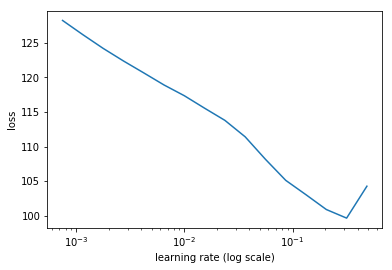

In [105]:
learn.lr_find()
learn.sched.plot()

In [106]:
lr=2e-2
#use_clr sets shed to use CircularLR
learn.fit(lrs=lr, n_cycle=1, cycle_len=3, use_clr=(32,5))

HBox(children=(IntProgress(value=0, description='Epoch', max=3), HTML(value='')))

epoch      trn_loss   val_loss   detn_acc   detn_l1    
    0      69.805835  46.594353  0.766076   32.644102 
    1      52.54062   36.139866  0.808444   25.051828 
    2      44.119135  35.166183  0.81866    24.418645 



[35.166183, 0.8186598569154739, 24.418644666671753]

In [107]:
learn.save('reg1_0')

In [108]:
#as we replaced the dataset with a ConcatLblData, we no longer have access to .sz property and learn.summary() throws an error, sz prperty added to ConcatLblData above

In [109]:
#learn.summary()

In [110]:
layer_groups = learn.get_layer_groups()
print(f'{layer_groups}, {len(layer_groups)}')

[[Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False), BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True), ReLU(inplace), MaxPool2d(kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), dilation=(1, 1), ceil_mode=False), Sequential(
  (0): BasicBlock(
    (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
    (relu): ReLU(inplace)
    (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
  )
  (1): BasicBlock(
    (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
    (relu): ReLU(inplace)
    (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
  )
  (2): BasicBlock(
 

In [111]:
#set to trainable the last two layer groups only 
learn.freeze_to(-2) 

In [112]:
#learn.sched.plot() cant run as CircularLR has no attribute plot

In [113]:
#learn.sched.plt_lr() ditto

In [114]:
lrs = np.array([lr/100, lr/10, lr])

In [115]:
learn.lr_find(lrs/1000)
learn.sched.plot(0)

HBox(children=(IntProgress(value=0, description='Epoch', max=1), HTML(value='')))

 88%|████████▊ | 28/32 [00:09<00:01,  3.00it/s, loss=166] 


In [116]:
learn.fit(lrs/5, n_cycle=1, cycle_len=5, use_clr=(32,10))

HBox(children=(IntProgress(value=0, description='Epoch', max=5), HTML(value='')))

epoch      trn_loss   val_loss   detn_acc   detn_l1    
    0      40.650861  38.224224  0.759766   23.133893 
    1      35.473997  34.908184  0.807091   20.904828 
    2      29.764813  33.199532  0.814002   20.012308 
    3      25.263166  32.661697  0.822266   19.461693 
    4      21.978222  32.13295   0.822266   19.213157 



[32.13295, 0.822265625, 19.213156938552856]

In [117]:
learn.save('reg1_1')

In [118]:
learn.load('reg1_1')

In [119]:
learn.unfreeze()

In [120]:
#to plot need to access lrs (ie from declr. above) and losses (tricky, need to work this out), cant plot below as 'CircularLR' object has no attribute 'plot'

In [121]:
#learn.sched.plot()

In [122]:
learn.fit(lrs=lrs/10, n_cycle=1, cycle_len=10, use_clr=(32, 10))

HBox(children=(IntProgress(value=0, description='Epoch', max=10), HTML(value='')))

epoch      trn_loss   val_loss   detn_acc   detn_l1    
    0      19.241953  36.15189   0.765325   20.198009 
    1      19.337856  36.637943  0.789513   20.134657 
    2      18.831725  34.260605  0.780349   19.112121 
    3      17.987396  33.131927  0.816406   18.986359 
    4      16.755159  32.869156  0.803185   18.548162 
    5      15.772697  32.655262  0.802734   18.603811 
    6      14.795778  31.970816  0.808143   18.48976  
    7      13.928871  32.0476    0.810096   18.363758 
    8      13.252518  32.087692  0.803335   18.355509 
    9      12.636047  31.573019  0.803335   18.026832 



[31.573019, 0.8033353388309479, 18.02683174610138]

In [123]:
learn.save('reg1')

In [124]:
learn.load('reg1')

In [127]:
preds = learn.predict()
x, _ = next(iter(md.val_dl))

preds[i][:4]: [-2.82359 -1.2057   2.32191  1.54746]
bb: [ 12.55802  51.62373 203.99123 184.69849]
preds[i][:4]: [-0.71106 -2.98321  1.74334  1.84159]
bb: [ 73.77789  10.79457 190.64879 193.34259]
preds[i][:4]: [-1.46385 -1.87765  2.26106  2.79671]
bb: [ 42.08486  29.71563 202.8545  211.11949]
preds[i][:4]: [-1.32377 -1.08711  3.41377  1.00938]
bb: [ 47.08278  56.48436 216.86156 164.16916]
preds[i][:4]: [-2.05044 -1.15611  4.17907  1.2361 ]
bb: [ 25.53771  53.61984 220.62167 173.57426]
preds[i][:4]: [-0.46921 -1.60665  0.39253  0.12182]
bb: [ 86.19579  37.42017 133.7035  118.81367]
preds[i][:4]: [-0.62108 -2.03907  2.61055  1.62506]
bb: [ 78.29585  25.79616 208.66446 187.1503 ]
preds[i][:4]: [ 0.52254 -1.57209  3.46075  0.51243]
bb: [140.614    38.50985 217.17923 140.08397]
preds[i][:4]: [-1.93709 -1.00255  2.65709  1.35803]
bb: [ 28.21677  60.13078 209.31601 178.17859]
preds[i][:4]: [-0.98905 -0.15219  0.5778   0.72461]
bb: [ 60.72655 103.49404 143.48543 150.89133]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


preds[i][:4]: [ 0.15614 -0.96863  2.41316  0.65146]
bb: [120.72598  61.63451 205.5928  147.24423]
preds[i][:4]: [-0.44423 -1.24276  0.52078  1.98656]
bb: [ 87.52448  50.16629 140.5218  196.98079]


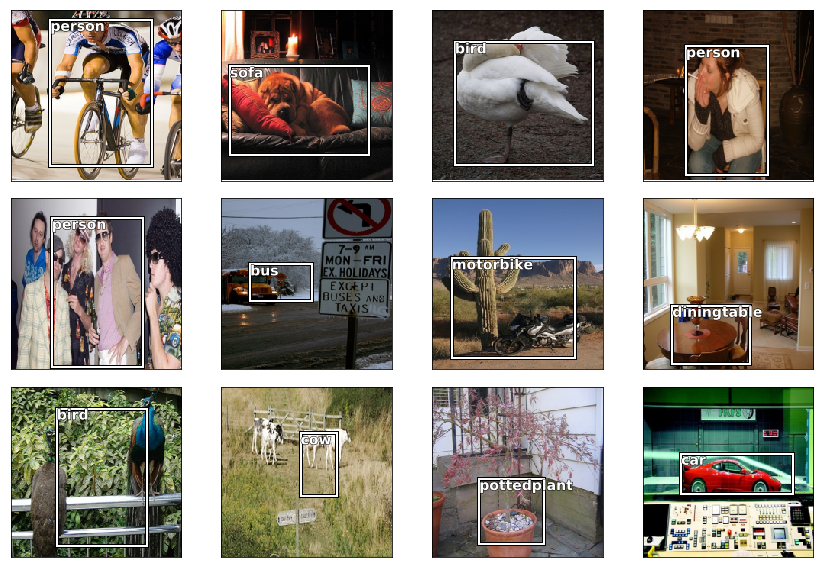

In [128]:
fig, axes = plt.subplots(3, 4, figsize=(12,8))
for i, ax in enumerate(axes.flat):
    #val_ds is val_dl.dataset but val_ds.ds?, 
    #.denorm is a method in FilesDataset where we reverse the normalization done to a batch of images
    ima = md.val_ds.ds.denorm(to_np(x))[i]
    #module scipy.special._ufuncs: The expit function, also known as the logistic function, is defined as
    #expit(x) = 1/(1+exp(-x)). It is the inverse of the logit function
    print(f'preds[i][:4]: {preds[i][:4]}')
    bb = expit(preds[i][:4])*224
    print(f'bb: {bb}')
    b = bb_hw(bb)
    c = np.argmax(preds[i][4:])
    ax = show_img(ima, ax=ax)
    draw_rect(ax, b)
    draw_text(ax, b[:2], md2.classes[c])
plt.tight_layout()